In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the aggregated data
X = pd.read_csv('input_data/processed/aggregated_data_001.csv')
print(X.shape)

(1308050, 37)


In [3]:
# We want to use plot the data later, thus we need to copy the original values of the temporal and spatial features and the fire IDs
temporal_spatial_features = ['FIRE_ID', 'ACQ_DATE', 'DAY_OF_YEAR', 'LATITUDE', 'LONGITUDE']
X_ts = X[temporal_spatial_features].copy()
X_ts.head()

,FIRE_ID,ACQ_DATE,DAY_OF_YEAR,LATITUDE,LONGITUDE
0,921182,2015-01-01,1,47.09,37.61
1,921184,2015-01-01,1,47.09,37.61
2,921183,2015-01-01,1,47.09,37.61
3,921181,2015-01-01,1,47.15,37.53
4,921185,2015-01-02,2,50.51,28.74


In [4]:
# Lets define which columns to keep
columns_to_keep = [
    'ACQ_DATE',
    'LATITUDE', 
    'LONGITUDE', 
    'DAY_OF_YEAR', 
    'FIRE_COUNT_CELL', 
    'FIRE_COUNT_CELL_NEIGHBOR_100km', 
    'FIRE_COUNT_CELL_NEIGHBOR_10km', 
    'FIRE_COUNT_CELL_AVG_7D',
    'FIRE_COUNT_CELL_NEIGHBOR_100km_AVG_7D',
    'FIRE_COUNT_CELL_NEIGHBOR_10km_AVG_7D',
    'FIRE_COUNT_CELL_AVG_30D',
    'FIRE_COUNT_CELL_NEIGHBOR_100km_AVG_30D',
    'FIRE_COUNT_CELL_NEIGHBOR_10km_AVG_30D',
    'POP_DENSITY_CELL_AVG',
    'POP_DENSITY_CELL_NEIGHBOR_100km_AVG',
    'POP_DENSITY_CELL_NEIGHBOR_10km_AVG',
    'LAND_USE_CLASS_1_NEIGHBOR_100km_AVG',
    'LAND_USE_CLASS_2_NEIGHBOR_100km_AVG',
    'LAND_USE_CLASS_3_NEIGHBOR_100km_AVG',
    'LAND_USE_CLASS_4_NEIGHBOR_100km_AVG',
    'LAND_USE_CLASS_1_NEIGHBOR_10km_AVG',
    'LAND_USE_CLASS_2_NEIGHBOR_10km_AVG',
    'LAND_USE_CLASS_3_NEIGHBOR_10km_AVG',
    'LAND_USE_CLASS_4_NEIGHBOR_10km_AVG'
    ]
# Drop the columns that we don't need
X = X.drop(columns=set(X.columns) - set(columns_to_keep))
X.shape

(1308050, 24)

In [5]:
# Get the data for those rows with ACQ_DATE smaller than 2022-02-24 (the first day of the UKR war)
# and for those rows with ACQ_DATE greater than 2022-02-24

# Data before the war
X_pre = X[X['ACQ_DATE'] < '2022-02-24']
X_ts_pre = X_ts[X['ACQ_DATE'] < '2022-02-24']
X_pre.drop(columns=['ACQ_DATE'], inplace=True)

# Data after the war
X_post = X[X['ACQ_DATE'] >= '2022-02-24']
X_ts_post = X_ts[X['ACQ_DATE'] >= '2022-02-24']
X_post.drop(columns=['ACQ_DATE'], inplace=True)

X_pre.shape, X_post.shape

((896367, 23), (411683, 23))

In [13]:
# Load the scaler and pca models
import pickle

with open('saved_models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('saved_models/pca.pkl', 'rb') as f:
    pca = pickle.load(f)

# Scale the data
X_pre_scaled = scaler.transform(X_pre)
X_pre_scaled = pd.DataFrame(X_pre_scaled, columns=X_pre.columns)

# Apply PCA
X_pre_pca = pca.transform(X_pre_scaled)
X_pre_pca = pd.DataFrame(X_pre_pca)
X_pre_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.656558,-0.678215,-1.859664,1.424718,-0.976618,0.001501,0.239020,-1.736837,-1.954300,0.586959,-0.151034,-1.620529,0.436219,-0.560386,0.081379,-0.068835,-0.487891
1,-0.647690,-0.691298,-1.874096,1.403695,-1.004557,0.026853,0.250652,-1.744076,-1.957556,0.586591,-0.152558,-1.618189,0.437219,-0.560003,0.080844,-0.085219,-0.488549
2,-0.638521,-0.704654,-1.888708,1.382388,-1.032845,0.052453,0.262381,-1.751393,-1.960853,0.586224,-0.154096,-1.615831,0.438225,-0.559636,0.080287,-0.102218,-0.489211
3,-1.718048,0.343951,-1.168152,2.178414,-0.270357,-0.779285,0.381045,-1.864667,-1.561887,1.269583,-0.269189,-1.284565,0.595722,-0.199417,0.102152,0.011054,-0.472778
4,-0.122715,3.902382,-0.421930,-0.922053,0.407163,0.044758,-0.466379,-0.265096,-1.893926,-0.058719,0.084620,-0.989201,-1.558197,0.743487,-0.420663,0.060998,-0.695242


In [16]:
# Load the cluster labels
y_labels = pd.read_csv('output_data/cluster_labels_pre_war.csv')
y_labels = np.array(y_labels['CLUSTER_LABEL'])
y_labels.shape

(896367,)

In [17]:
# Lets train a model to predict the cluster labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

# Split the data into training and testing sets
X_pre_train, X_pre_test, y_pre_train, y_pre_test = train_test_split(X_pre_pca, y_labels, test_size=0.2)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_pre_train, y_pre_train)

# Predict the cluster labels
y_pre_proba = rf.predict_proba(X_pre_test)

# Get the predicted cluster labels from the probabilities
y_pre_pred = np.argmax(y_pre_proba, axis=1)

# Calculate the balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_pre_test, y_pre_pred)
balanced_accuracy

np.float64(0.981633915694182)

In [18]:
# Save the model as a pickle file
with open('saved_models/rf_clf.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [19]:
# Apply the scaler and PCA to X_post data
X_post_scaled = scaler.transform(X_post)
X_post_scaled = pd.DataFrame(X_post_scaled, columns=X_post.columns)
X_post_pca = pca.transform(X_post_scaled)
X_post_pca = pd.DataFrame(X_post_pca)
# X_post_pca = pd.DataFrame(X_post_scaled)

X_post_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.588820,-1.016815,-1.783910,-2.076573,0.654462,0.197086,2.253439,-0.277216,-2.682158,0.385490,-2.906589,1.919144,1.208921,-1.540741,0.989394,0.980276,-0.172615
1,-0.884047,0.792722,-0.268941,-0.309631,1.811257,-0.492367,1.177045,-0.185543,-1.857215,0.353044,-2.058891,0.778669,1.514230,-1.068849,0.184543,0.151770,0.130660
2,0.159773,0.297125,-0.887448,-0.667535,2.380221,-1.068284,1.938351,-0.031795,-2.423232,0.229321,-2.785629,1.785648,1.081187,-1.731094,0.918276,0.492205,-0.138273
3,0.974793,-0.405031,-1.290924,-1.382928,1.468777,-0.480020,2.207886,-0.275777,-2.529071,0.253644,-2.831809,1.833792,1.112096,-1.715484,0.884992,-0.664936,-0.150953
4,1.859198,-1.165124,-1.741320,-2.102374,0.573329,0.287857,2.279393,-0.303115,-2.686826,0.383999,-2.912693,1.918131,1.208355,-1.538349,0.986355,0.827591,-0.173205


In [21]:
# Predict the cluster labels for the X_post data
y_post_proba = rf.predict_proba(X_post_pca)
y_post_pred = np.argmax(y_post_proba, axis=1)
y_post_pred.shape, y_post_proba.shape

((411683,), (411683, 15))

In [24]:
from scipy.stats import entropy

# Calculate the entropy of the predicted probabilities for pre and post war data
entropy_pre = entropy(y_pre_proba, axis=1)
entropy_post = entropy(y_post_proba, axis=1)

# Set a threshold for out-of-distribution detection based on the pre-war data entropy
threshold_entropy = np.percentile(entropy_pre, 95)  # X-th percentile

# Detect out-of-distribution points in the post-war data
ood = pd.Series(entropy_post > threshold_entropy)

# Adjust the indices to fit with the original data
ood.index = X_post.index

# List the indices of out-of-distribution points
ood_indices = list(ood[ood].index)

# Print the results
print(f"Number of out-of-distribution points based on entropy: {ood.sum()}")
print(f"Indices of out-of-distribution points based on entropy: {ood_indices}")
print(f"Relative amount of out-of-distribution points based on entropy: {ood.mean()}")

Number of out-of-distribution points based on entropy: 90042
Indices of out-of-distribution points based on entropy: [896379, 896381, 896384, 896387, 896390, 896391, 896397, 896398, 896399, 896401, 896403, 896404, 896438, 896440, 896441, 896442, 896464, 896471, 896489, 896526, 896528, 896542, 896545, 896546, 896547, 896572, 896595, 896601, 896604, 896605, 896606, 896608, 896611, 896618, 896629, 896630, 896656, 896657, 896658, 896668, 896669, 896670, 896687, 896692, 896693, 896694, 896695, 896696, 896697, 896705, 896714, 896734, 896736, 896737, 896738, 896740, 896742, 896761, 896769, 896775, 896776, 896779, 896783, 896798, 896801, 896810, 896811, 896823, 896824, 896850, 896854, 896861, 896863, 896909, 896922, 896928, 896939, 896948, 896969, 897011, 897024, 897038, 897048, 897049, 897087, 897091, 897096, 897102, 897119, 897123, 897124, 897125, 897126, 897128, 897129, 897132, 897135, 897147, 897152, 897158, 897162, 897175, 897178, 897184, 897187, 897195, 897202, 897209, 897210, 897211, 89

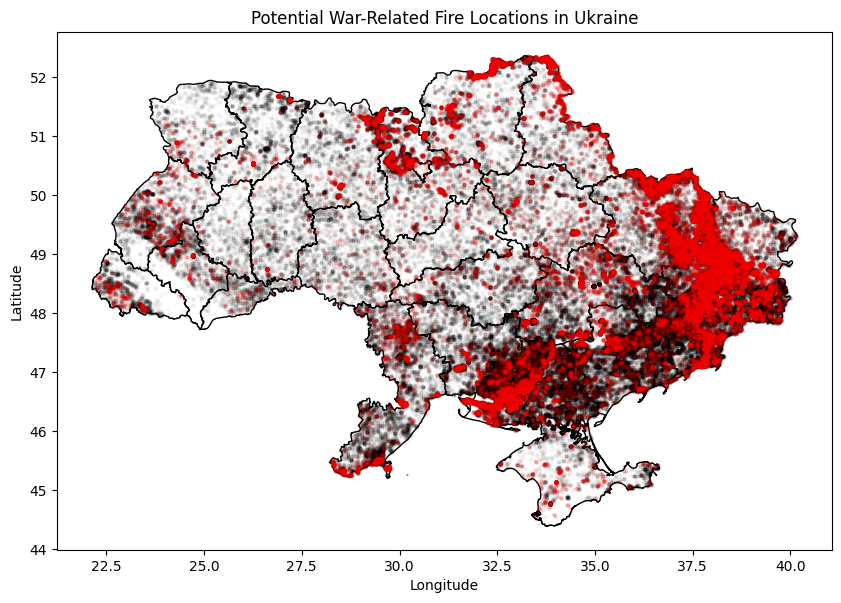

In [25]:
import geopandas as gpd

import matplotlib.pyplot as plt

# Load the shapefile containing the administrative borders of Ukraine
ukraine_borders = gpd.read_file('input_data/raw/ukr_borders/ua.shp')

# Ensure the aggregated_data_sample is a GeoDataFrame
# Select only the out-of-distribution samples
ood_df = gpd.GeoDataFrame(X_ts_post.loc[ood_indices], geometry=gpd.points_from_xy(X_ts_post.loc[ood_indices].LONGITUDE, X_ts_post.loc[ood_indices].LATITUDE))
# Select only the non out-of-distribution samples
n_ood_df = gpd.GeoDataFrame(X_ts_post.loc[~ood], geometry=gpd.points_from_xy(X_ts_post.loc[~ood].LONGITUDE, X_ts_post.loc[~ood].LATITUDE))

# Set the same coordinate reference system (CRS) for both GeoDataFrames
ood_df.set_crs(epsg=4326, inplace=True)
n_ood_df.set_crs(epsg=4326, inplace=True)
ukraine_borders.set_crs(epsg=4326, inplace=True)

# Plot the Ukraine map and the clustered samples
fig, ax = plt.subplots(figsize=(10, 10))
ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
# Plot the non out-of-distribution samples in black with high transparency
n_ood_df.plot(ax=ax, color='black', markersize=5, alpha=0.025)
# Plot the out-of-distribution samples in red with high transparency
ood_df.plot(ax=ax, color='red', markersize=5, alpha=0.05)
plt.title('Potential War-Related Fire Locations in Ukraine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()